# Trans-effects summary figure

In [117]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm
import scipy
import pertpy
import yaml

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15


from DE_analysis_utils import *

In [3]:
with open('../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

In [4]:
OAKPATH  = '/mnt/oak/'

## Load gene lists

In [96]:

def parse_gene_sets(filename):
   gene_sets = {}
   with open(filename, 'r') as f:
       for line in f:
           terms = line.strip().split('\t')
           gene_sets[terms[0]] = terms[2:]
   return gene_sets
KEGG_sets = parse_gene_sets(f'/mnt/oak/users/emma/data//KEGG_2019_Human.txt')

In [97]:
import json
import re

def extract_genes_from_kegg_json(json_file_path):
    """
    Extract all gene names from KEGG cytokine receptor JSON file.
    
    Args:
        json_file_path (str): Path to the JSON file
    
    Returns:
        list: List of gene names (e.g., ['IL2RA', 'IL2RB', ...])
    """
    
    def extract_genes_recursive(node):
        """Recursively extract genes from nested structure"""
        genes = []
        
        if isinstance(node, dict):
            # Check if this node has a 'name' field with gene info
            if 'name' in node:
                name = node['name']
                # Look for pattern: "number GENE_NAME; description"
                match = re.match(r'^\d+\s+(\w+);', name)
                if match:
                    gene_name = match.group(1)
                    genes.append(gene_name)
            
            # Recursively process children
            if 'children' in node:
                for child in node['children']:
                    genes.extend(extract_genes_recursive(child))
        
        elif isinstance(node, list):
            # If it's a list, process each item
            for item in node:
                genes.extend(extract_genes_recursive(item))
                
        return genes
    
    # Load JSON file
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Extract genes
    genes = extract_genes_recursive(data)
    
    # Remove duplicates and sort
    unique_genes = sorted(list(set(genes)))
    
    return unique_genes

# KEGG cytokines and receptors
gene_list = extract_genes_from_kegg_json('../../metadata/hsa04050.json')
# Optional: Save to file
with open('../../metadata/cytokine_receptors.tsv', 'w') as f:
    for gene in gene_list:
        f.write(gene + '\n')


gene_list = extract_genes_from_kegg_json('../../metadata/hsa04052.json')
# Optional: Save to file
with open('../../metadata/gene_lists/cytokines.tsv', 'w') as f:
    for gene in gene_list:
        f.write(gene + '\n')


In [99]:
schmidt_df

Unnamed: 0      id  num     neg|score   neg|p-value  neg|fdr  neg|rank  \
0               0    VAV1   12  2.310000e-36  2.610000e-07  0.00015         1   
1               1    LCP2   12  3.190000e-35  2.610000e-07  0.00015         2   
2               2    CD3G   12  2.450000e-29  2.610000e-07  0.00015         3   
3               3     IL2   12  5.390000e-29  2.610000e-07  0.00015         4   
4               4    CD3D   12  5.930000e-29  2.610000e-07  0.00015         5   
...           ...     ...  ...           ...           ...      ...       ...   
37873       37873    SLA2   12  1.000000e+00  1.000000e+00  1.00000     18935   
37874       37874    TSC1   12  1.000000e+00  1.000000e+00  1.00000     18936   
37875       37875     CD5   12  1.000000e+00  1.000000e+00  1.00000     18937   
37876       37876    CBLB   12  1.000000e+00  1.000000e+00  1.00000     18938   
37877       37877  MAP4K1   12  1.000000e+00  1.000000e+00  1.00000     18939   

       neg|goodsgrna  neg|lfc     pos|score   pos|p-value   pos|fdr  pos|rank  \
0                 12  -2.9160  1.000000e+00  1.000000e+00  1.000000     18937   
1                 12  -1.8811  1.000000e+00  1.000000e+00  1.000000     18935   
2                 12  -2.6665  1.000000e+00  1.000000e+00  1.000000     18930   
3                 11  -2.6101  1.000000e+00  9.999900e-01  1.000000     18920   
4                 10  -2.4943  9.958600e-01  9.917900e-01  0.999727     18785   
...              ...      ...           ...           ...       ...       ...   
37873              0   0.8722  1.240000e-17  2.610000e-07  0.000092         6   
37874              0   1.1330  2.030000e-17  2.610000e-07  0.000092         7   
37875              0   1.3563  8.920000e-25  2.610000e-07  0.000092         1   
37876              0   1.2674  4.800000e-21  2.610000e-07  0.000092         2   
37877              0   1.1545  3.420000e-20  2.610000e-07  0.000092         3   

       pos|goodsgrna  pos|lfc  phenotype  
0                  0  -2.9160   CD4+ IL2  
1                  0  -1.8811   CD4+ IL2  
2                  0  -2.6665   CD4+ IL2  
3                  0  -2.6101   CD4+ IL2  
4                  0  -2.4943   CD4+ IL2  
...              ...      ...        ...  
37873             12   0.8722  CD8+ IFNG  
37874             12   1.1330  CD8+ IFNG  
37875             12   1.3563  CD8+ IFNG  
37876             12   1.2674  CD8+ IFNG  
37877             12   1.1545  CD8+ IFNG  

[37878 rows x 16 columns]

In [102]:
gene_list_labels = {
    'kinases': 'Protein Kinases',
    # 'core_essentials_hart': 'Core Essential Genes (Hart et al.)',
    'clinvar_path_likelypath': 'ClinVar disease genes',
    'gpi_anchored': 'GPI-Anchored Proteins',
    'transporters': 'Membrane Transporters',
    'gwascatalog': 'Genes near GWAS peaks',
    # 'rhodop_gpcr': 'Rhodopsin GPCRs',
    'enzymes': 'Enzymes',
    'catalytic_receptors': 'Catalytic Receptors',
    'gpcr_union': 'GPCRs',
    'nuclear_receptors': 'Nuclear Receptors',
    'ion_channels': 'Ion Channels',
    'olfactory_receptors': 'Olfactory Receptors',
    'IEI genes': 'Inborn Errors of Immunity Genes',
    'cytokines': 'Cytokines (KEGG)',
    'cytokine_receptors': 'Cytokine receptors (KEGG)',
    'Schmidt2022 IL2 CRISPRi pos': 'IL2 Positive Regulators (Schmidt 2022)',
    'Schmidt2022 IL2 CRISPRi neg': 'IL2 Negative Regulators (Schmidt 2022)'
}

lists_dict = {}

for f in os.listdir(f"../../metadata/gene_lists/"):
    key = f.split('.')[0]
    if key in gene_list_labels.keys():
        lists_dict[gene_list_labels[key]] = [g.strip() for g in open(f"../../metadata/gene_lists/{f}")]

# Inborn errors of immunity
IEI_genes = pd.read_csv('../../metadata/IUIS-IEI-list-July-2024V2.csv')
lists_dict['Inborn Errors of Immunity Genes'] = IEI_genes['Genetic defect'].unique()

# Activation screens
schmidt_df = pd.read_csv('../../metadata/SchmidtSteinhart2022_CRISPRi_screen_gene_phenotypes.csv')
lists_dict['IL2 Regulators (Schmidt 2022)'] = schmidt_df[(schmidt_df['phenotype'] == 'Prim.CRi.CD4.IL2') & ((schmidt_df['neg|p-value'] < 0.01) | (schmidt_df['pos|p-value'] < 0.01))]['id'].tolist()

# Human TFs
TFs = pd.read_csv('../../metadata/Lambert_2018_HumanTF.csv')
lists_dict['Transcription factors'] = TFs[TFs['is_TF'] == 'Yes'].Name.unique()

## Read DE analysis results

In [5]:
# Import utility functions from DE_analysis_utils.py
import sys
sys.path.append(os.path.abspath('../3_DE_analysis'))
from DE_analysis_utils import get_DE_results_long


In [60]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/CD4i_final.merged_DE_results.h5ad')
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50

# Filter very lowly expressed genes
base_mean_df = sc.get.obs_df(adata_de, adata_de.var_names.tolist() + ['culture_condition', 'chunk'], layer='baseMean')
base_mean_df = base_mean_df.drop_duplicates().sort_values('culture_condition')

# Calculate for Rest condition
base_mean_rest = base_mean_df[base_mean_df['culture_condition'] == 'Rest'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Rest'] = base_mean_rest.mean(1).fillna(0)
adata_de.var['std_baseMean_Rest'] = base_mean_rest.std(1).fillna(10000)

# Calculate for Stim8hr condition
base_mean_stim8 = base_mean_df[base_mean_df['culture_condition'] == 'Stim8hr'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Stim8hr'] = base_mean_stim8.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim8hr'] = base_mean_stim8.std(1).fillna(10000)

# Calculate for Stim48hr condition
base_mean_stim48 = base_mean_df[base_mean_df['culture_condition'] == 'Stim48hr'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Stim48hr'] = base_mean_stim48.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim48hr'] = base_mean_stim48.std(1).fillna(10000)

# Exclude from analysis genes with very low base mean (messing up reliability estimate)
gs_mask = (adata_de.var['mean_baseMean_Rest'] > 0.1) & (adata_de.var['mean_baseMean_Stim8hr'] > 0.1) & (adata_de.var['mean_baseMean_Stim48hr'] > 0.1)
adata_de = adata_de[:, gs_mask].copy()
sum(~gs_mask)

3677

In [61]:
adata_de_corr = anndata.experimental.read_lazy(datadir + f'/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad')
target_contrast_correction_dict = dict(zip(adata_de_corr.obs.to_dataframe()['target_contrast'], adata_de_corr.obs.to_dataframe()['target_contrast_corrected']))
target_contrast_name_correction_dict = dict(zip(adata_de_corr.obs.to_dataframe()['target_contrast_gene_name'], adata_de_corr.obs.to_dataframe()['target_contrast_gene_name_corrected']))

adata_de.obs['target_contrast_gene_name'] = adata_de.obs['target_contrast_gene_name'].map(target_contrast_name_correction_dict)
adata_de.obs['target_contrast'] = adata_de.obs['target_contrast'].map(target_contrast_correction_dict)

In [62]:
# remove missing perturb
adata_de = adata_de[~adata_de.obs['target_contrast_gene_name'].isna()].copy()

In [ ]:
adata_de.var_names = adata_de.var['gene_name'].values

target_contrast target_name condition  n_cells_target  n_up_genes  \
0  ENSG00000012963        UBR7   Stim8hr           491.0           0   
1  ENSG00000017260      ATP2C1   Stim8hr           469.0           0   
2  ENSG00000067606       PRKCZ   Stim8hr           427.0           1   
3  ENSG00000092929      UNC13D   Stim8hr           830.0           0   
4  ENSG00000100504        PYGL   Stim8hr           414.0           1   

   n_down_genes  n_total_de_genes  ontarget_effect_size  ontarget_significant  \
0             2                 2            -12.952742                  True   
1             1                 1            -16.307246                  True   
2             1                 2             -1.658755                 False   
3             2                 2            -19.259466                  True   
4             0                 1              0.000000                 False   

     baseMean  offtarget_flag n_total_genes_category ontarget_effect_category  \
0   43.169196            True          2-10 DE genes             on-target KD   
1  102.399025           False              1 DE gene             on-target KD   
2    0.965897           False          2-10 DE genes          no on-target KD   
3   60.904483           False          2-10 DE genes             on-target KD   
4         NaN           False              1 DE gene          no on-target KD   

  target_contrast_corrected                obs_names target_name_corrected  
0           ENSG00000012963  ENSG00000012963_Stim8hr                  UBR7  
1           ENSG00000017260  ENSG00000017260_Stim8hr                ATP2C1  
2           ENSG00000067606  ENSG00000067606_Stim8hr                 PRKCZ  
3           ENSG00000092929  ENSG00000092929_Stim8hr                UNC13D  
4           ENSG00000100504  ENSG00000100504_Stim8hr                  PYGL

In [65]:
for cond in adata_de.obs.culture_condition.unique():
    affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['adj_p_value'] < 0.1, axis=0)
    adata_de.var[f'n_signif_effects_{cond}'] = affected_gs_cond

In [82]:
# Load summary stats per regulator
DE_stats_targets = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)
# ontarget_df = pd.read_csv(f'{datadir}/DE_results_all_confounders/on_target_effects.csv')
DE_stats_targets['n_regulators'] = np.where(DE_stats_targets['ontarget_significant'], DE_stats_targets['n_total_de_genes'] - 1, DE_stats_targets['n_total_de_genes'])
DE_stats_targets.head()

target_contrast target_name condition  n_cells_target  n_up_genes  \
0  ENSG00000012963        UBR7   Stim8hr           491.0           0   
1  ENSG00000017260      ATP2C1   Stim8hr           469.0           0   
2  ENSG00000067606       PRKCZ   Stim8hr           427.0           1   
3  ENSG00000092929      UNC13D   Stim8hr           830.0           0   
4  ENSG00000100504        PYGL   Stim8hr           414.0           1   

   n_down_genes  n_total_de_genes  ontarget_effect_size  ontarget_significant  \
0             2                 2            -12.952742                  True   
1             1                 1            -16.307246                  True   
2             1                 2             -1.658755                 False   
3             2                 2            -19.259466                  True   
4             0                 1              0.000000                 False   

     baseMean  offtarget_flag n_total_genes_category ontarget_effect_category  \
0   43.169196            True          2-10 DE genes             on-target KD   
1  102.399025           False              1 DE gene             on-target KD   
2    0.965897           False          2-10 DE genes          no on-target KD   
3   60.904483           False          2-10 DE genes             on-target KD   
4         NaN           False              1 DE gene          no on-target KD   

  target_contrast_corrected                obs_names target_name_corrected  \
0           ENSG00000012963  ENSG00000012963_Stim8hr                  UBR7   
1           ENSG00000017260  ENSG00000017260_Stim8hr                ATP2C1   
2           ENSG00000067606  ENSG00000067606_Stim8hr                 PRKCZ   
3           ENSG00000092929  ENSG00000092929_Stim8hr                UNC13D   
4           ENSG00000100504  ENSG00000100504_Stim8hr                  PYGL   

   n_regulators  
0             1  
1             0  
2             2  
3             1  
4             1

In [89]:
basemean_genes.columns

Index(['gene_name', 'culture_condtition', 'baseMean'], dtype='object')

In [92]:
# Get summary stats per measured gene
DE_stats_genes = pd.concat([
    get_de_stats(adata_de[adata_de.obs['culture_condition'] == c], alpha=0.1, signif_col='adj_p_value', effect_col='zscore', axis='genes').assign(culture_condition=c)
    for c in adata_de.obs['culture_condition'].unique()
])
DE_stats_genes.head()

basemean_genes = pd.concat([ pd.DataFrame(np.nanmean(adata_de[adata_de.obs.culture_condition == c].layers['baseMean'], axis=0), index=adata_de.var_names, columns=[c]) for c in adata_de.obs['culture_condition'].unique()], axis=1)
basemean_genes = basemean_genes.reset_index().melt(id_vars=['index'], var_name='culture_condition', value_name='baseMean').fillna(0).rename(columns={'index':'gene_name'})

DE_stats_genes = pd.merge(DE_stats_genes, basemean_genes, how='left')
DE_stats_genes = pd.merge(DE_stats_genes, DE_stats_targets[['target_name', 'condition', 'ontarget_significant']].rename(columns={'target_name':'gene_name', 'condition':'culture_condition'}), how='left')
DE_stats_genes['n_regulators'] = np.where(DE_stats_genes['ontarget_significant'], DE_stats_genes['n_total_de_targets'] - 1, DE_stats_genes['n_total_de_targets'])
DE_stats_genes.head()

gene_id gene_name  n_up_targets  n_down_targets  \
0  ENSG00000000419      DPM1            63              46   
1  ENSG00000000457     SCYL3            75               7   
2  ENSG00000000460  C1orf112            20              49   
3  ENSG00000000971       CFH            27               0   
4  ENSG00000001036     FUCA2            62               8   

   n_total_de_targets culture_condition    baseMean ontarget_significant  \
0                 109           Stim8hr  162.840391                 True   
1                  82           Stim8hr   23.346474                 True   
2                  69           Stim8hr   48.368208                 True   
3                  27           Stim8hr    0.263675                False   
4                  70           Stim8hr   12.618764                 True   

   n_regulators  
0           108  
1            81  
2            68  
3            27  
4            69

/tmp/ipykernel_571142/3204648076.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right', frameon=False, title='Culture condition', title_fontsize=12, fontsize=10)


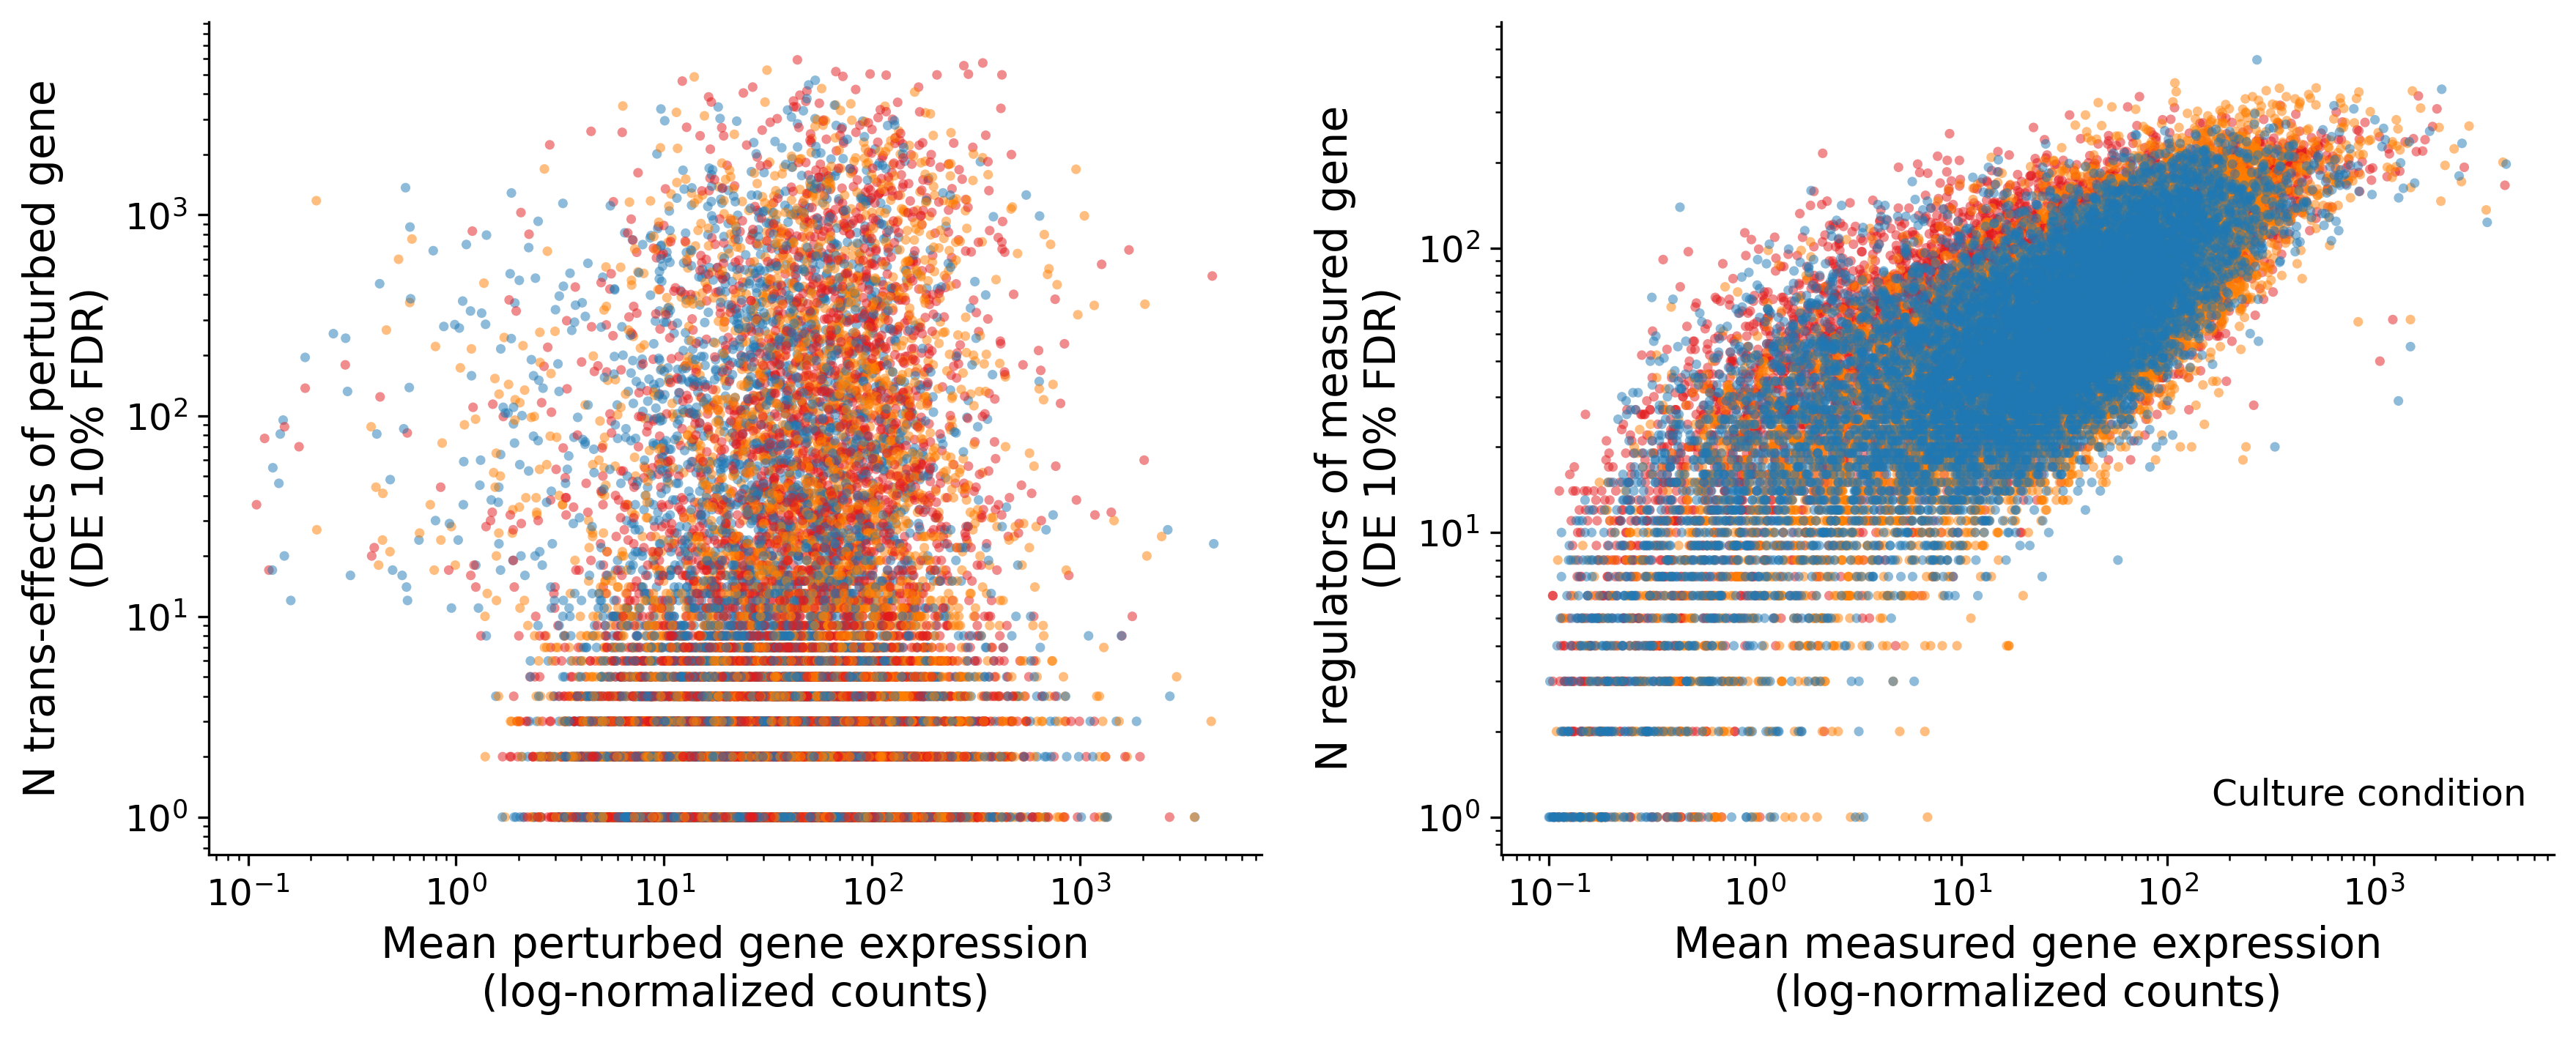

In [121]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

scatter1 = ax1.scatter(DE_stats_targets['baseMean'], DE_stats_targets['n_total_de_genes'], 
                       c=[palettes['culture_condition'][cond] for cond in DE_stats_targets['condition']], 
                       s=10, alpha=0.5, linewidth=0, rasterized=True)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set(ylabel='N trans-effects of perturbed gene\n(DE 10% FDR)', xlabel='Mean perturbed gene expression\n(log-normalized counts)')
ax1.legend([], frameon=False)
ax1.tick_params(axis='both', labelsize=12)
ax1.set_xlabel(ax1.get_xlabel(), fontsize=14)
ax1.set_ylabel(ax1.get_ylabel(), fontsize=14)

scatter2 = ax2.scatter(DE_stats_genes['baseMean'], DE_stats_genes['n_regulators'],
                       c=[palettes['culture_condition'][cond] for cond in DE_stats_genes['culture_condition']], 
                       s=10, alpha=0.5, linewidth=0, rasterized=True)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set(ylabel='N regulators of measured gene\n(DE 10% FDR)', xlabel='Mean measured gene expression\n(log-normalized counts)')
ax2.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right', frameon=False, title='Culture condition', title_fontsize=12, fontsize=10)
ax2.tick_params(axis='both', labelsize=12)
ax2.set_xlabel(ax2.get_xlabel(), fontsize=14)
ax2.set_ylabel(ax2.get_ylabel(), fontsize=14)

sns.despine()
plt.tight_layout()
plt.savefig('results/network_structure.vs_basemean.pdf', bbox_inches='tight', dpi=300)

## Outgoing effects summary

In [123]:
DE_stats_targets = DE_stats_targets[DE_stats_targets['ontarget_significant']]

# Iterate through culture conditions
results = []
for condition in DE_stats_targets['condition'].unique():
    condition_data = DE_stats_targets[DE_stats_targets['condition'] == condition]
    
    # Iterate through gene lists
    for name, l in lists_dict.items():
        # Get subset of targets data for genes in current list
        df = condition_data[condition_data.target_name.isin(l)]
        
        # For each gene in the list, create a row with group name and DE gene count
        for _, row in df.iterrows():
            results.append({
                'grp': name.split('.')[0],
                'X': row['n_total_de_genes'], 
                'group_mean': df['n_total_de_genes'].mean(),
                'condition': condition
            })
        
    df = condition_data.copy()
    for _, row in df.iterrows():
        results.append({
            'grp': 'all genes',
            'X': row['n_total_de_genes'], 
            'group_mean': df['n_total_de_genes'].mean(),
            'condition': condition
        })

# Convert results to dataframe        
df_filtered = pd.DataFrame(results)
df_filtered[df_filtered['grp'] == 'kinases']
df_filtered['log_X'] = np.log10(df_filtered['X'])
df_filtered['condition'] = pd.Categorical(df_filtered['condition'], categories=['Rest', 'Stim8hr', 'Stim48hr'], ordered=True)

/tmp/ipykernel_571142/412273049.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (condition, data) in enumerate(all_genes_data.groupby('condition')):
/tmp/ipykernel_571142/412273049.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()
/tmp/ipykernel_571142/412273049.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (conditi

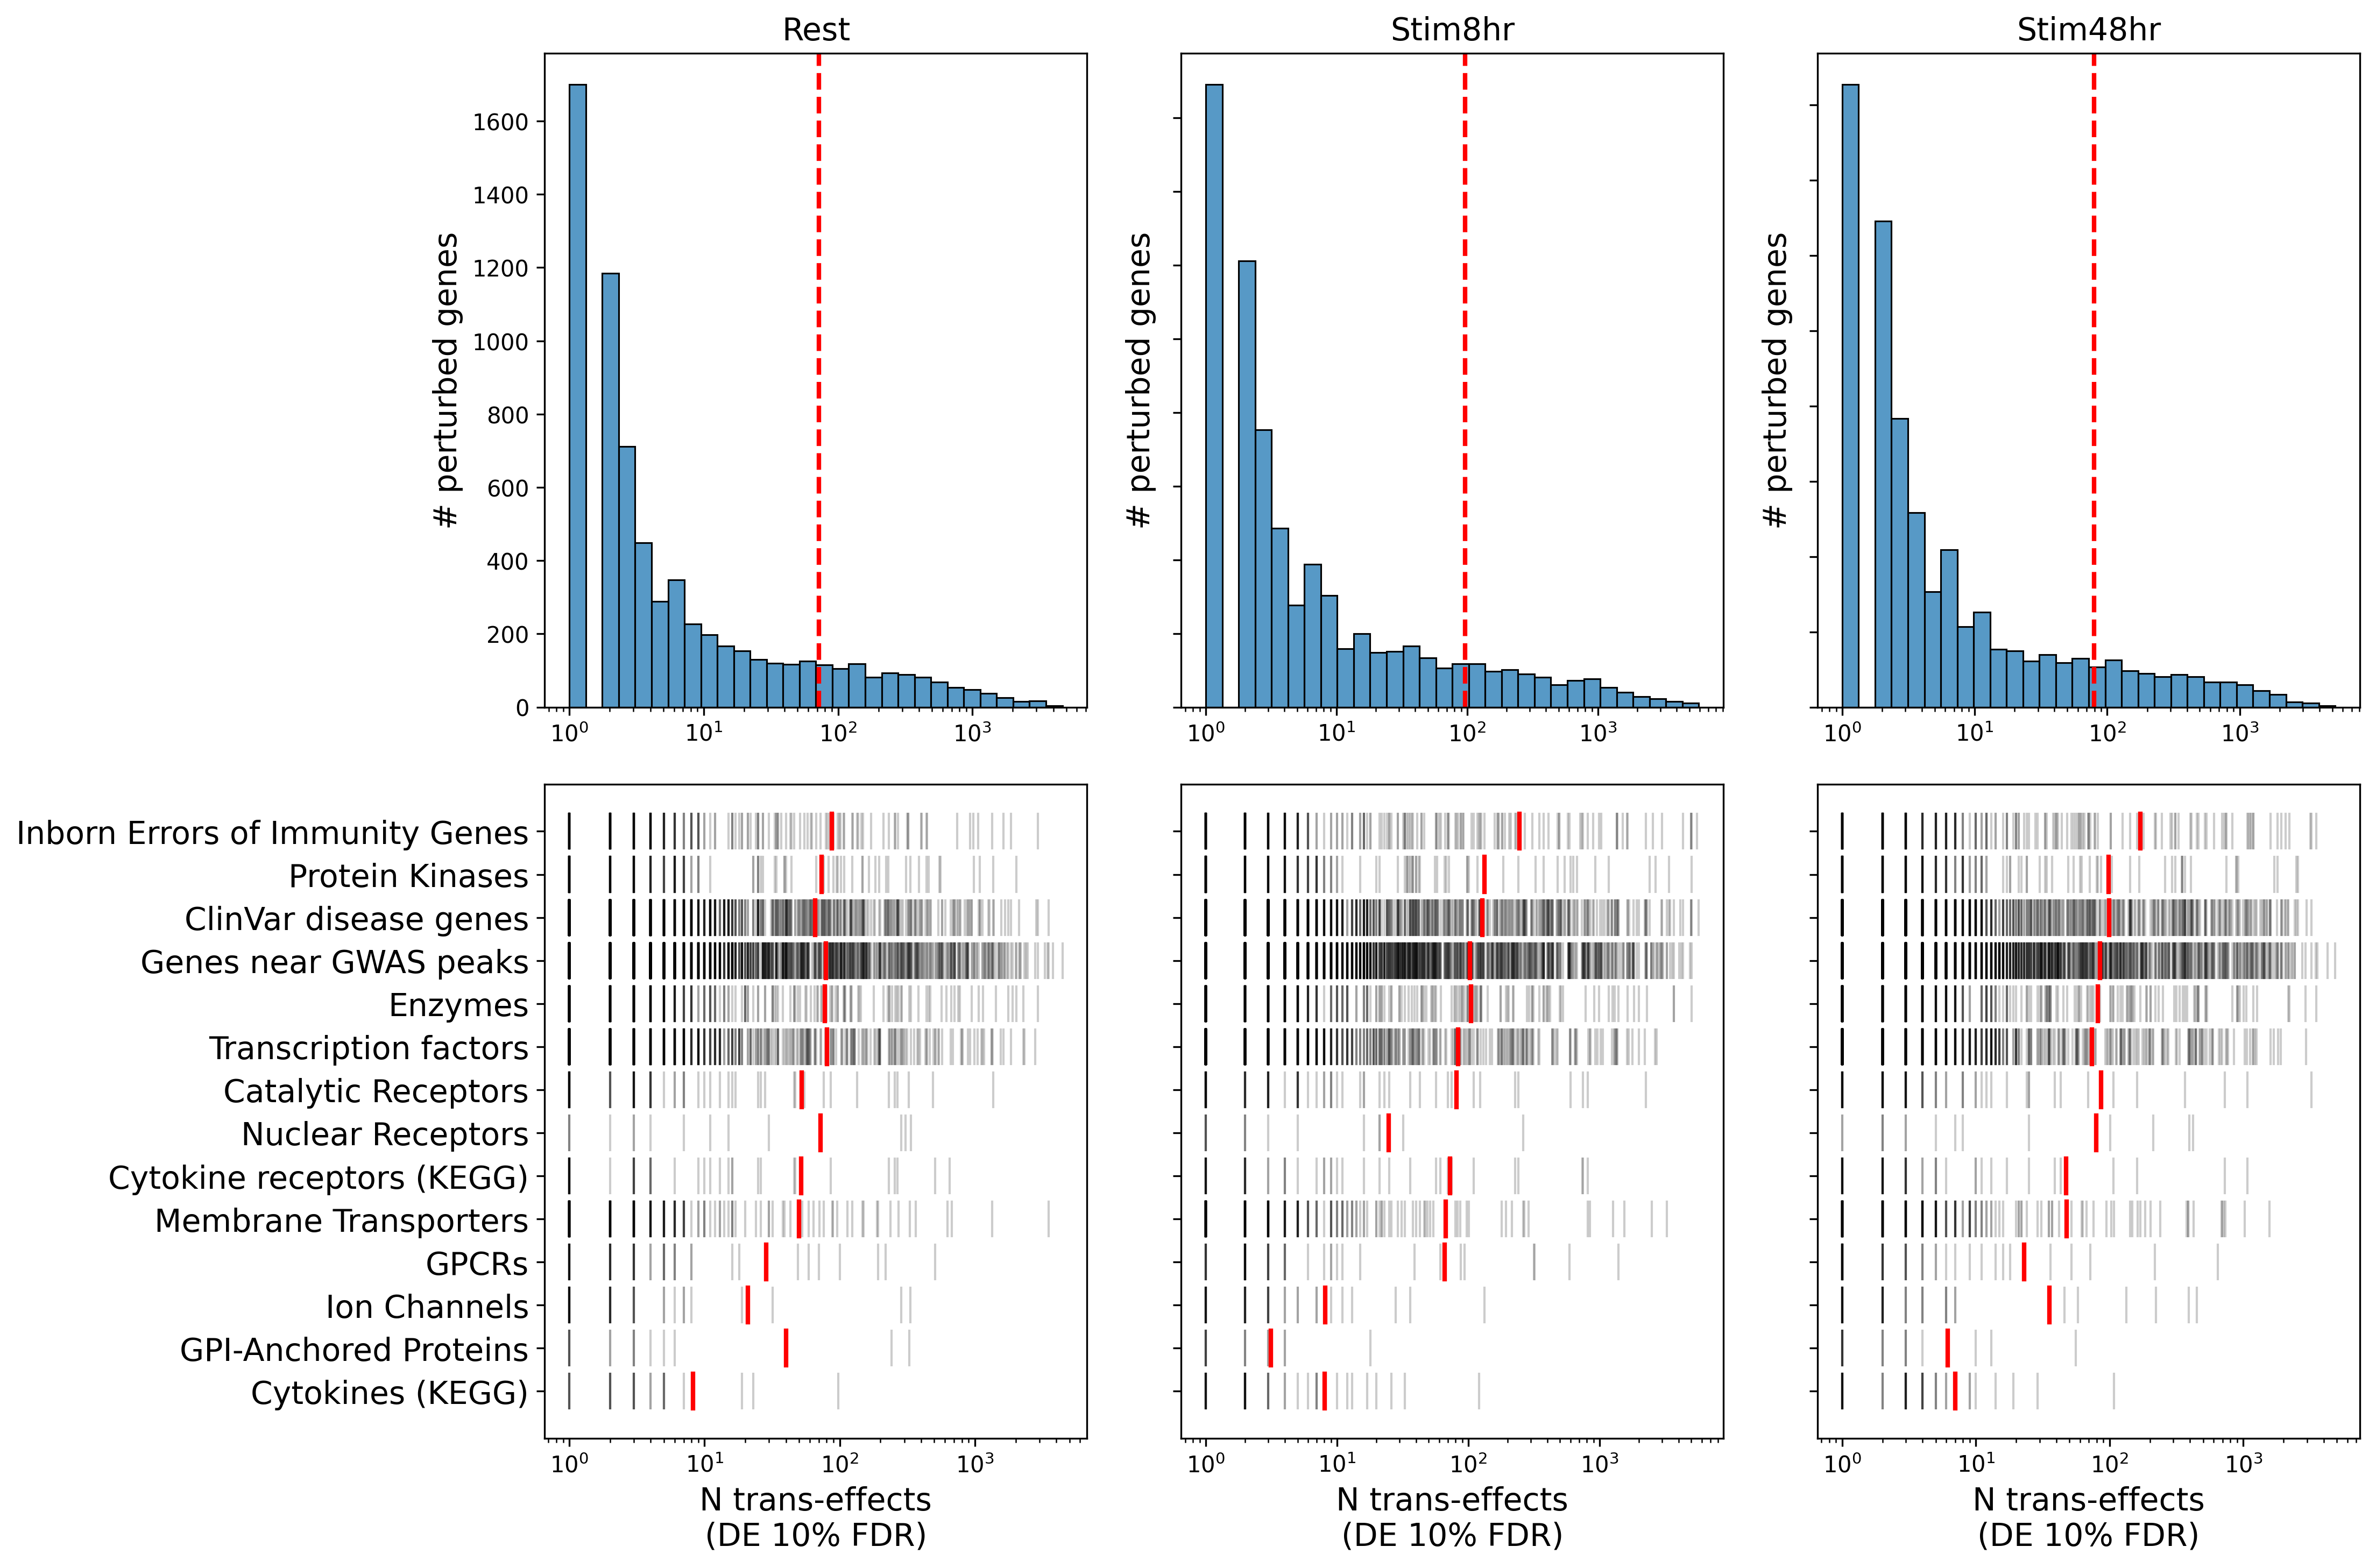

In [124]:
# Calculate mean log_X for each group and sort
group_means = df_filtered.groupby('grp')['X'].mean().sort_values()
sorted_groups = group_means.index.tolist()

# Create figure with 2 rows of 3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10), height_ratios=[1, 1])

# Get all genes data for histograms
all_genes_data = df_filtered[df_filtered.grp == 'all genes']

# Plot histograms in top row
for i, (condition, data) in enumerate(all_genes_data.groupby('condition')):
    sns.histplot(data=data, x='X', bins=30, ax=axes[0,i], common_norm=False, log_scale=True)
    
    # Add mean as red dotted line
    mean_val = data['X'].mean()
    axes[0,i].axvline(mean_val, color='red', linestyle='--', linewidth=2)
    
    axes[0,i].set_title(condition, fontsize=14)
    axes[0,i].set_xlabel('', fontsize=14)  
    axes[0,i].set_ylabel('# perturbed genes', fontsize=14)
    axes[0,i].tick_params(axis='both', labelsize=10)
    if i > 0:
        axes[0,i].set_yticklabels([])

# Filter data and calculate means for bottom row
filtered_data = df_filtered[df_filtered.grp != 'all genes']
means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()

# Get groups that actually have data (to remove unused y-axis labels)
groups_with_data = filtered_data['grp'].unique()
sorted_groups_with_data = [grp for grp in sorted_groups if grp in groups_with_data]

# Plot stripplots in bottom row
for i, (condition, data) in enumerate(filtered_data.groupby('condition')):
    # Create rug plot - one line per gene
    for j, group in enumerate(sorted_groups_with_data):
        group_data = data[data['grp'] == group]
        
        # Plot horizontal lines for each gene in this group
        for _, gene in group_data.iterrows():
            axes[1,i].plot([gene['X'], gene['X']], [j-0.4, j+0.4], 
                          color='black', alpha=0.2, linewidth=1)
        
        # Calculate and plot mean line
        mean_x = group_data['X'].mean()
        axes[1,i].plot([mean_x, mean_x], [j-0.4, j+0.4],
                      color='red', linewidth=2, zorder=10)
    
    axes[1,i].set_title('')
    axes[1,i].set_xscale('log')
    axes[1,i].set_yticks(range(len(sorted_groups_with_data)))
    axes[1,i].set_yticklabels(sorted_groups_with_data, fontsize=14)
    axes[1,i].set_xlabel('N trans-effects\n(DE 10% FDR)', fontsize=14)
    axes[1,i].tick_params(axis='x', labelsize=10)

    if i > 0:
        axes[1,i].set_yticklabels([])

plt.tight_layout()

In [125]:
df_filtered[df_filtered['grp'] == 'all genes']['X'].mean()

82.61095399698341

/tmp/ipykernel_571142/964365825.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for condition, data in all_genes_data.groupby('condition'):
/tmp/ipykernel_571142/964365825.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()
/tmp/ipykernel_571142/964365825.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for condition, condition_data i

TypeError: FigureCanvasAgg.print_png() got an unexpected keyword argument 'rasterized'

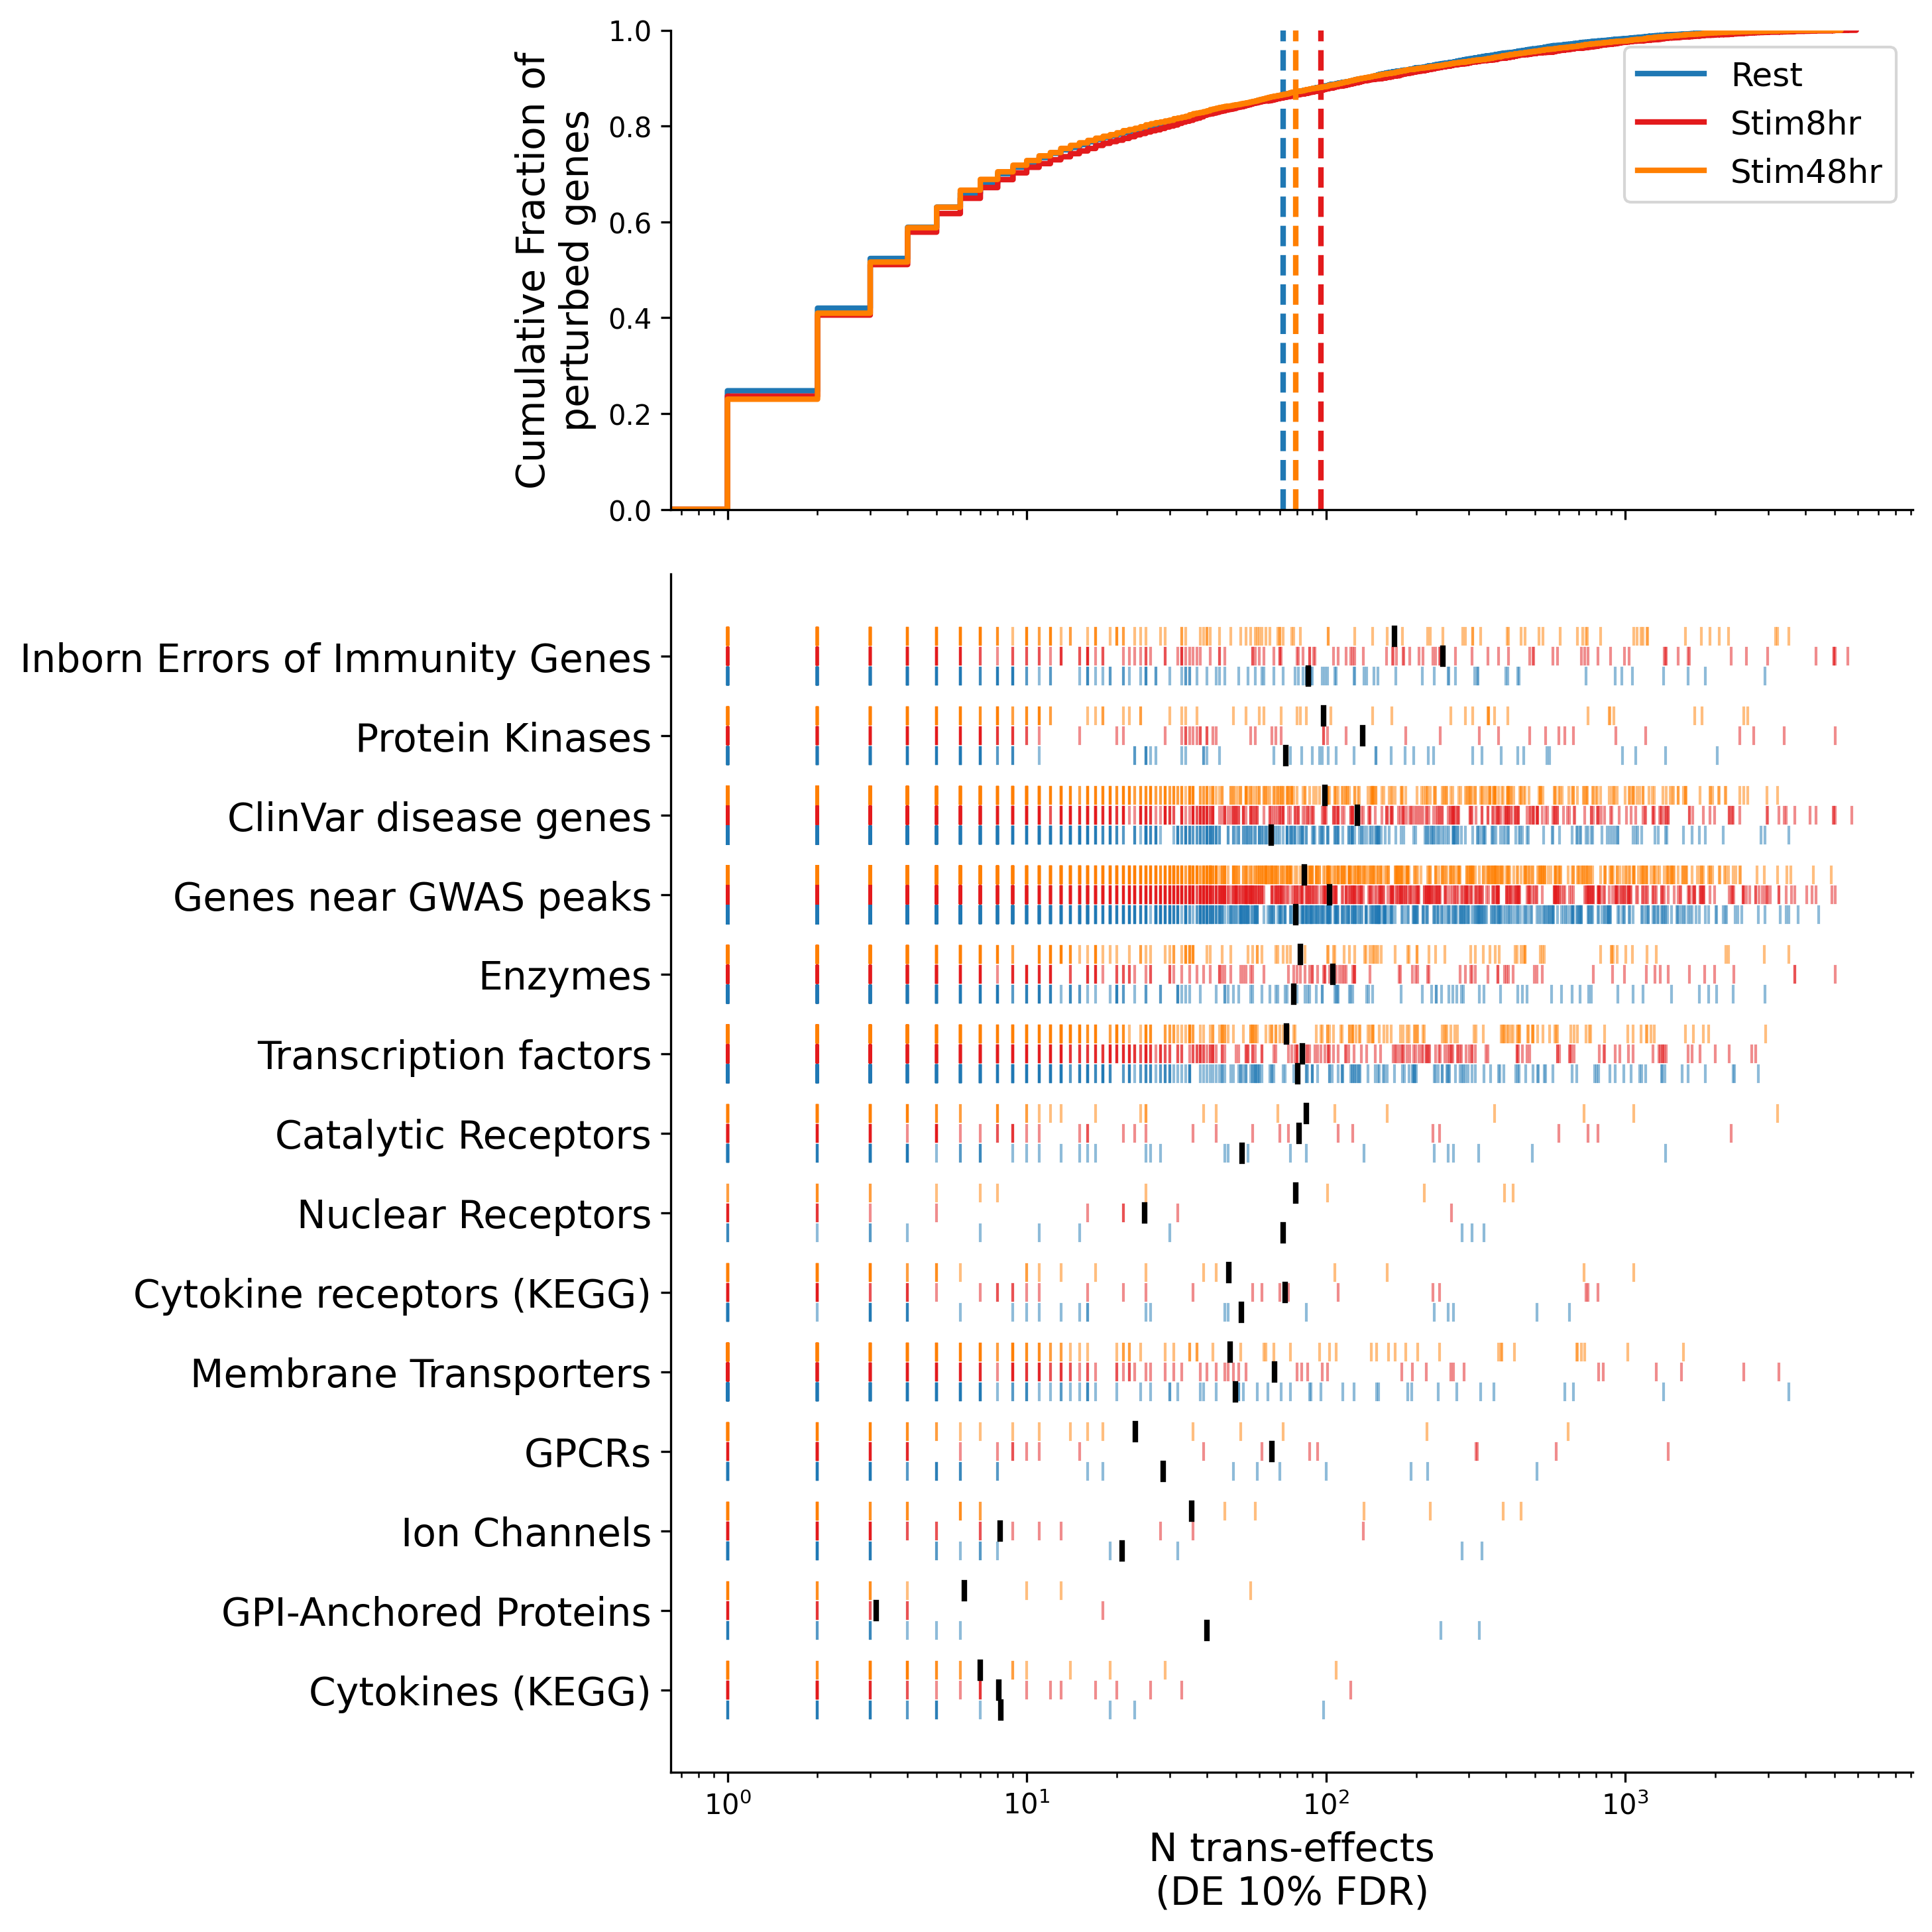

In [126]:
# Calculate mean log_X for each group and sort
group_means = df_filtered.groupby('grp')['X'].mean().sort_values()
sorted_groups = group_means.index.tolist()

# Create figure with 2 subplots in one column
fig, axes = plt.subplots(2, 1, figsize=(10, 10), height_ratios=[1, 2.5], sharex=True)

# Get all genes data for histograms
all_genes_data = df_filtered[df_filtered.grp == 'all genes']

# Define colors for each condition
condition_colors = palettes['culture_condition']

# Plot density lines in top subplot
for condition, data in all_genes_data.groupby('condition'):
    # Plot Empirical Cumulative Distribution Function (ECDF)
    sns.ecdfplot(data=data, x='X', ax=axes[0],
                 color=condition_colors[condition], 
                 label=condition, linewidth=2, log_scale=True)
    
    # Add mean as vertical line in same color
    mean_val = data['X'].mean()
    axes[0].axvline(mean_val, color=condition_colors[condition],
                    linestyle='--', linewidth=2)

# Add vertical line at x=0
axes[0].axvline(0, color='grey', linestyle=':', linewidth=1)
axes[0].set_xlabel('N trans-effects', fontsize=14)
axes[0].set_ylabel('Cumulative Fraction of\nperturbed genes', fontsize=14)
axes[0].tick_params(axis='both', labelsize=10)
axes[0].legend(fontsize=12)
sns.despine(ax=axes[0])

# Filter data and calculate means for bottom subplot
filtered_data = df_filtered[df_filtered.grp != 'all genes']
means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()

# Get groups that actually have data
groups_with_data = filtered_data['grp'].unique()
sorted_groups_with_data = [grp for grp in sorted_groups if grp in groups_with_data]

# Add vertical line at x=0
axes[1].axvline(0, color='grey', linestyle=':', linewidth=1)
# Create rug plot - one line per gene, colored by condition
for j, group in enumerate(sorted_groups_with_data):
    group_data = filtered_data[filtered_data['grp'] == group]
    
    # Calculate offsets for each condition to dodge the lines
    conditions = list(condition_colors.keys())
    offsets = {cond: (i-1)*0.25 for i, cond in enumerate(conditions)}
    
    for condition, condition_data in group_data.groupby('condition'):
        # Plot horizontal lines for each gene in this group, with offset
        y_offset = j + offsets[condition]
        for _, gene in condition_data.iterrows():
            axes[1].plot([gene['X'], gene['X']], 
                        [y_offset-0.1, y_offset+0.1],
                        color=condition_colors[condition], 
                        alpha=0.5, linewidth=1, rasterized=True)
        
        # Calculate and plot mean line with same offset
        mean_x = condition_data['X'].mean()
        axes[1].plot([mean_x, mean_x], 
                    [y_offset-0.1, y_offset+0.1],
                    color='black', 
                    linewidth=2, zorder=10, rasterized=True)

axes[1].set_yticks(range(len(sorted_groups_with_data)))
axes[1].set_yticklabels(sorted_groups_with_data, fontsize=14)
axes[1].set_xlabel('N trans-effects\n(DE 10% FDR)', fontsize=14)
axes[1].tick_params(axis='x', labelsize=10)
axes[1].set_xscale('log')  # Set x-axis to log scale
sns.despine(ax=axes[1])

plt.tight_layout()
plt.savefig('results/network_structure.regulators.pdf', bbox_inches='tight', dpi=300)
plt.savefig('results/network_structure.regulators.png', bbox_inches='tight', dpi=300, rasterized=True)

## Incoming effects summary

/tmp/ipykernel_571142/3557306439.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_data['fit_residuals'] = residuals


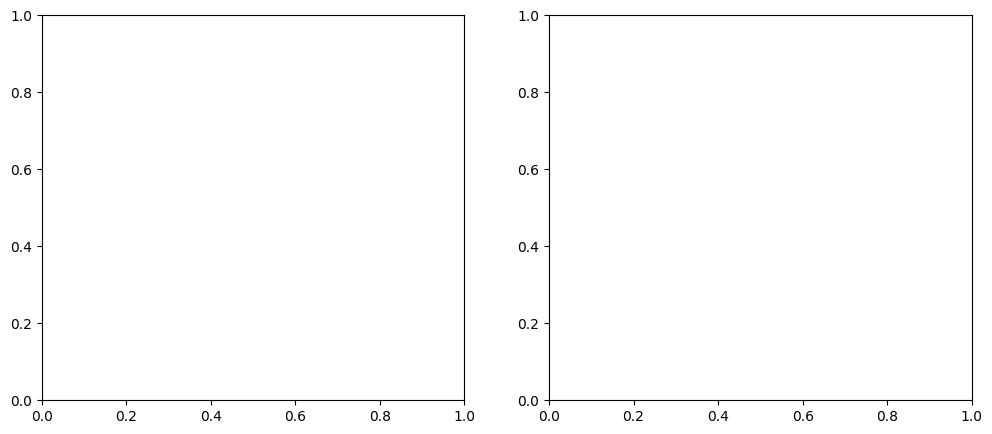

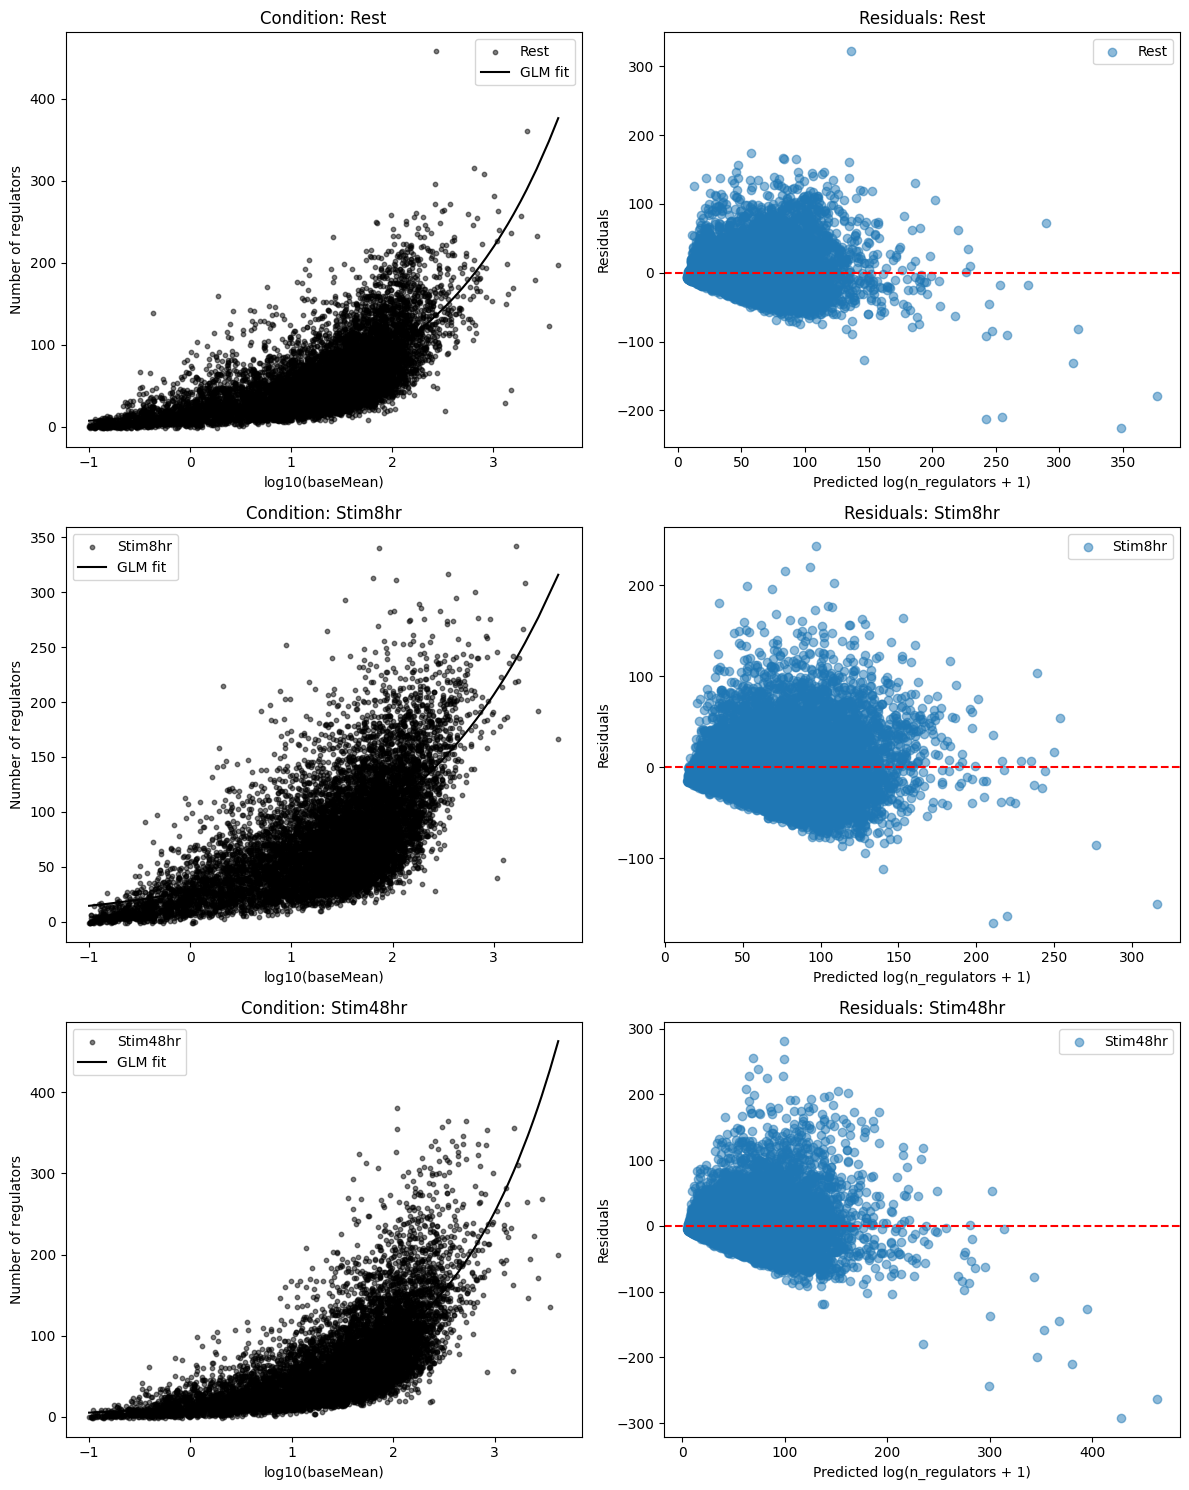

In [ ]:
DE_stats_genes = DE_stats_genes[DE_stats_genes['baseMean'] > 0]

from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Prepare data for GLM for each condition separately
fig, axes = plt.subplots(len(conditions), 2, figsize=(12, 5*len(conditions)))

for i, condition in enumerate(conditions):
    # Filter data for current condition
    condition_data = DE_stats_genes[DE_stats_genes['culture_condition'] == condition]
    
    # Calculate percentiles to exclude extreme outliers for this condition
    baseMean_values = condition_data['baseMean'].values
    lower_percentile = np.percentile(baseMean_values[baseMean_values > 0], 1)
    upper_percentile = np.percentile(baseMean_values, 99)

    # Create mask for non-outlier values
    non_outlier_mask = (baseMean_values >= lower_percentile) & (baseMean_values <= upper_percentile)

    # Prepare data using non-outlier values
    X_glm = sm.add_constant(np.log10(baseMean_values[non_outlier_mask]))
    poisson_model = sm.GLM(condition_data.loc[non_outlier_mask, 'n_regulators'].values, 
                           X_glm, family=sm.families.Poisson())
    poisson_results = poisson_model.fit()

    # Get residuals for all, including outliers
    fitted_values = poisson_results.predict(sm.add_constant(np.log10(condition_data['baseMean'].values)))
    residuals = condition_data['n_regulators'].values - fitted_values  # Calculate residuals as observed - predicted

    # Save residuals to the original dataframe for this condition
    condition_data['fit_residuals'] = residuals
    DE_stats_genes.loc[condition_data.index, 'fit_residuals'] = residuals

    # Scatter plot of n_regulators vs baseMean
    X_plot = np.log10(condition_data['baseMean'].values)
    axes[i, 0].scatter(X_plot, 
                       condition_data['n_regulators'].values, 
                       s=10, color='black', alpha=0.5, label=condition)
    
    # Sort X values and get corresponding fitted values for smooth line
    sort_idx = np.argsort(X_plot)
    X_plot_sorted = X_plot[sort_idx]
    fitted_values_sorted = fitted_values[sort_idx]
    
    axes[i, 0].plot(X_plot_sorted, fitted_values_sorted, color='black', label='GLM fit')
    axes[i, 0].set_xlabel('log10(baseMean)')
    axes[i, 0].set_ylabel('Number of regulators')
    axes[i, 0].set_title(f'Condition: {condition}')
    axes[i, 0].legend()

    # Residuals plot
    axes[i, 1].scatter(fitted_values, 
                       residuals, 
                       alpha=0.5, label=condition)
    axes[i, 1].axhline(y=0, color='r', linestyle='--')
    axes[i, 1].set_xlabel('Predicted log(n_regulators + 1)')
    axes[i, 1].set_ylabel('Residuals')
    axes[i, 1].set_title(f'Residuals: {condition}')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Iterate through culture conditions
results = []
for condition in DE_stats_genes['culture_condition'].unique():
    condition_data = DE_stats_genes[DE_stats_genes['culture_condition'] == condition]
    
    # Iterate through gene lists
    for name, l in lists_dict.items():
        # Get subset of targets data for genes in current list
        df = condition_data[condition_data.gene_name.isin(l)]
        
        # For each gene in the list, create a row with group name and DE gene count
        for _, row in df.iterrows():
            results.append({
                'grp': name.split('.')[0],
                'X': row['fit_residuals'], 
                'group_mean': df['fit_residuals'].mean(),
                'condition': condition
            })
        
    df = condition_data.copy()
    for _, row in df.iterrows():
        results.append({
            'grp': 'all genes',
            'X': row['fit_residuals'], 
            'group_mean': df['fit_residuals'].mean(),
            'condition': condition
        })

# Convert results to dataframe        
df_filtered = pd.DataFrame(results)
df_filtered['log_X'] = np.log10(df_filtered['X'])
df_filtered['condition'] = pd.Categorical(df_filtered['condition'], categories=['Rest', 'Stim8hr', 'Stim48hr'], ordered=True)

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/tmp/ipykernel_571142/1676628330.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (condition, data) in enumerate(all_genes_data.groupby('condition')):
/tmp/ipykernel_571142/1676628330.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()
/tmp/ipykernel_571142/1676628330.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (cond

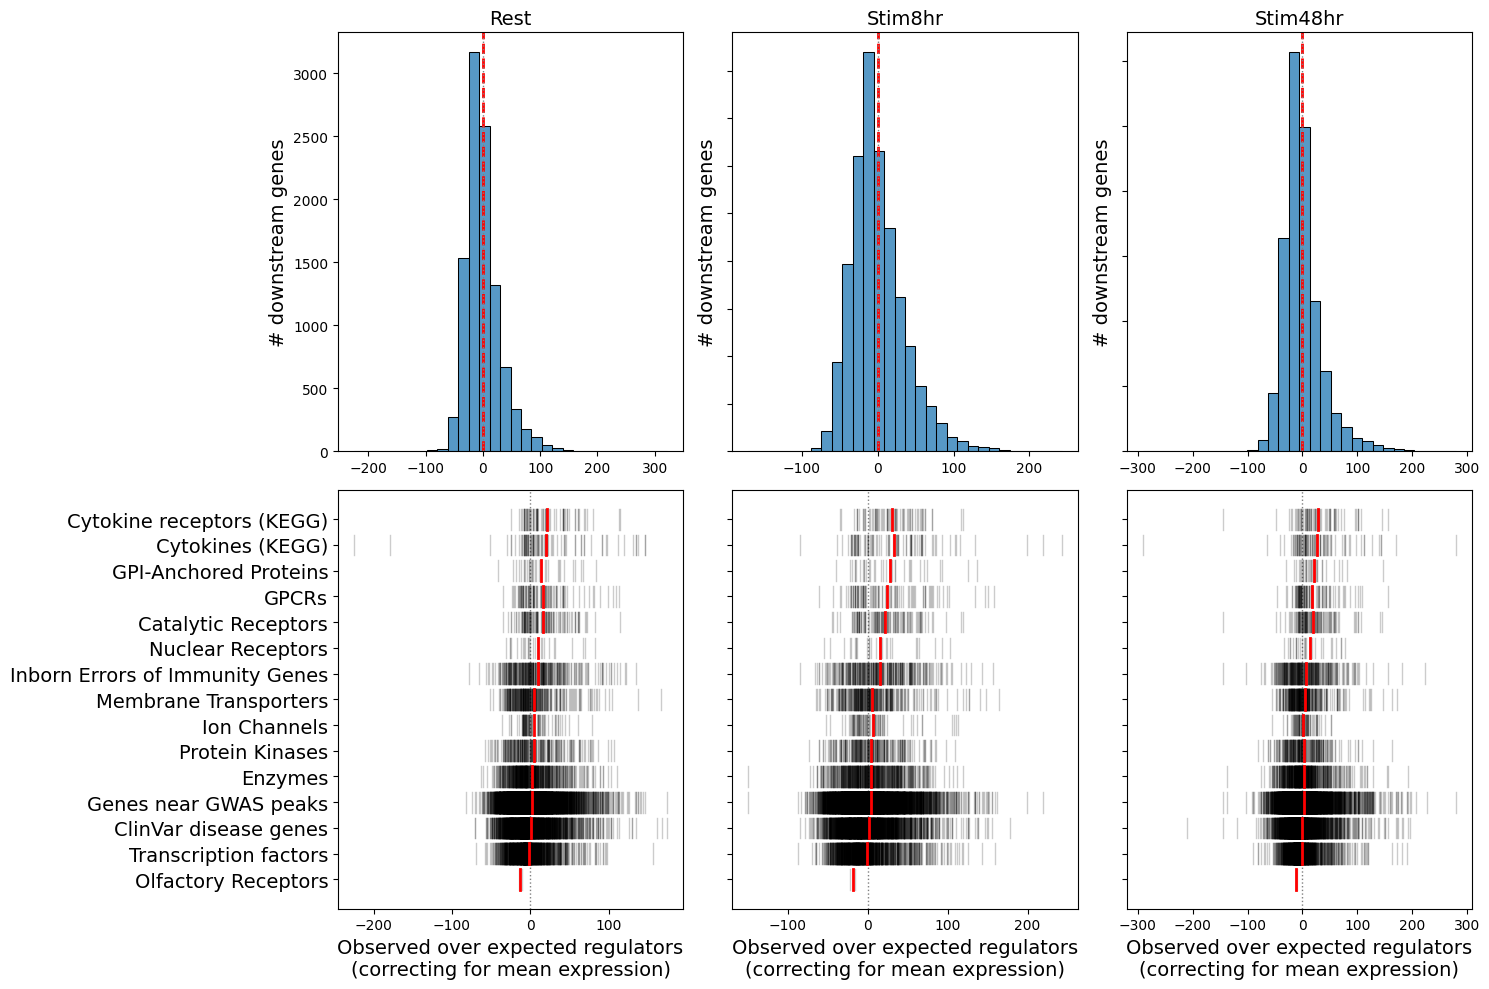

In [ ]:
# Calculate mean log_X for each group and sort
group_means = df_filtered.groupby('grp')['X'].mean().sort_values()
sorted_groups = group_means.index.tolist()

# Create figure with 2 rows of 3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10), height_ratios=[1, 1])

# Get all genes data for histograms
all_genes_data = df_filtered[df_filtered.grp == 'all genes']

# Plot histograms in top row
for i, (condition, data) in enumerate(all_genes_data.groupby('condition')):
    sns.histplot(data=data, x='X', bins=30, ax=axes[0,i], common_norm=False)
    
    # Add mean as red dotted line
    mean_val = data['X'].mean()
    axes[0,i].axvline(mean_val, color='red', linestyle='--', linewidth=2)
    
    # Add vertical line at x=0
    axes[0,i].axvline(0, color='grey', linestyle=':', linewidth=1)
    
    axes[0,i].set_title(condition, fontsize=14)
    axes[0,i].set_xlabel('', fontsize=14)  
    axes[0,i].set_ylabel('# downstream genes', fontsize=14)
    axes[0,i].tick_params(axis='both', labelsize=10)
    if i > 0:
        axes[0,i].set_yticklabels([])

# Filter data and calculate means for bottom row
filtered_data = df_filtered[df_filtered.grp != 'all genes']
means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()

# Get groups that actually have data (to remove unused y-axis labels)
groups_with_data = filtered_data['grp'].unique()
sorted_groups_with_data = [grp for grp in sorted_groups if grp in groups_with_data]

# Plot stripplots in bottom row
for i, (condition, data) in enumerate(filtered_data.groupby('condition')):
    # Add vertical line at x=0
    axes[1,i].axvline(0, color='grey', linestyle=':', linewidth=1)
    
    # Create rug plot - one line per gene
    for j, group in enumerate(sorted_groups_with_data):
        group_data = data[data['grp'] == group]
        
        # Plot horizontal lines for each gene in this group
        for _, gene in group_data.iterrows():
            axes[1,i].plot([gene['X'], gene['X']], [j-0.4, j+0.4], 
                          color='black', alpha=0.2, linewidth=1)
        
        # Calculate and plot mean line
        mean_x = group_data['X'].mean()
        axes[1,i].plot([mean_x, mean_x], [j-0.4, j+0.4],
                      color='red', linewidth=2, zorder=10)
    
    axes[1,i].set_title('')
    # axes[1,i].set_xscale('log')
    axes[1,i].set_yticks(range(len(sorted_groups_with_data)))
    axes[1,i].set_yticklabels(sorted_groups_with_data, fontsize=14)
    axes[1,i].set_xlabel('Observed over expected regulators\n(correcting for mean expression)', fontsize=14)
    axes[1,i].tick_params(axis='x', labelsize=10)

    if i > 0:
        axes[1,i].set_yticklabels([])

plt.tight_layout()

/tmp/ipykernel_571142/2063516979.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for condition, data in all_genes_data.groupby('condition'):
/tmp/ipykernel_571142/2063516979.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()
/tmp/ipykernel_571142/2063516979.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for condition, condition_dat

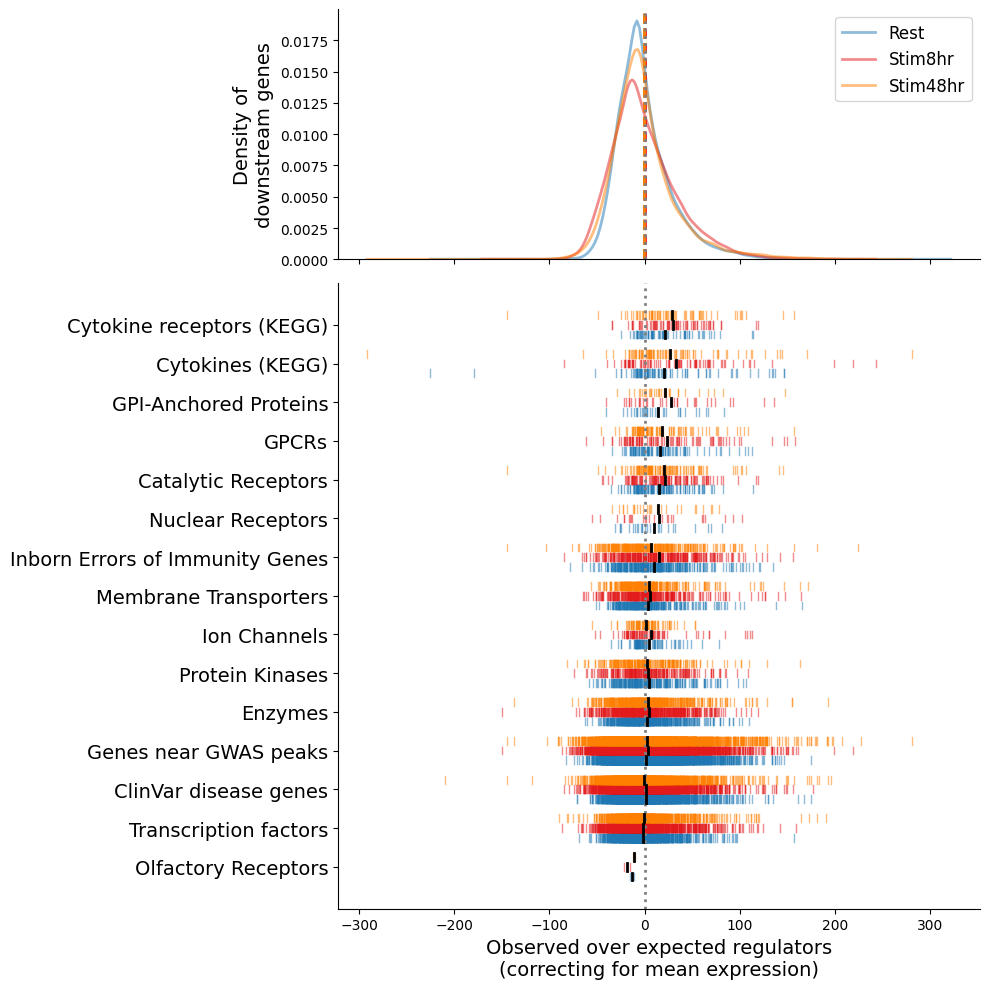

In [ ]:
# Calculate mean log_X for each group and sort
group_means = df_filtered.groupby('grp')['X'].mean().sort_values()
sorted_groups = group_means.index.tolist()

# Create figure with 2 subplots in one column
fig, axes = plt.subplots(2, 1, figsize=(10, 10), height_ratios=[1, 2.5], sharex=True)

# Get all genes data for histograms
all_genes_data = df_filtered[df_filtered.grp == 'all genes']

# Define colors for each condition
condition_colors = palettes['culture_condition']

# Plot density lines in top subplot
for condition, data in all_genes_data.groupby('condition'):
    sns.kdeplot(data=data, x='X', ax=axes[0],
                color=condition_colors[condition], alpha=0.5,
                label=condition, linewidth=2,
                clip=(data['X'].min(), data['X'].max()))
    # Add mean as vertical line in same color
    mean_val = data['X'].mean()
    axes[0].axvline(mean_val, color=condition_colors[condition],
                    linestyle='--', linewidth=2)

# Add vertical line at x=0
axes[0].axvline(0, color='grey', linestyle=':', linewidth=2)
axes[0].set_xlabel('', fontsize=14)
axes[0].set_ylabel('Density of\ndownstream genes', fontsize=14)
axes[0].tick_params(axis='both', labelsize=10)
axes[0].legend(fontsize=12)
sns.despine(ax=axes[0])

# Filter data and calculate means for bottom subplot
filtered_data = df_filtered[df_filtered.grp != 'all genes']
means = filtered_data.groupby(['grp', 'condition'])['X'].mean().reset_index()

# Get groups that actually have data
groups_with_data = filtered_data['grp'].unique()
sorted_groups_with_data = [grp for grp in sorted_groups if grp in groups_with_data]

# Add vertical line at x=0
# Create rug plot - one line per gene, colored by condition
for j, group in enumerate(sorted_groups_with_data):
    group_data = filtered_data[filtered_data['grp'] == group]
    
    # Calculate offsets for each condition to dodge the lines
    conditions = list(condition_colors.keys())
    offsets = {cond: (i-1)*0.25 for i, cond in enumerate(conditions)}
    
    for condition, condition_data in group_data.groupby('condition'):
        # Plot horizontal lines for each gene in this group, with offset
        y_offset = j + offsets[condition]
        for _, gene in condition_data.iterrows():
            axes[1].plot([gene['X'], gene['X']], 
                        [y_offset-0.1, y_offset+0.1],
                        color=condition_colors[condition], 
                        alpha=0.5, linewidth=1, rasterized=True)
        
        # Calculate and plot mean line with same offset
        mean_x = condition_data['X'].mean()
        axes[1].plot([mean_x, mean_x], 
                    [y_offset-0.1, y_offset+0.1],
                    color='black', 
                    linewidth=2, zorder=10, rasterized=True)
axes[1].axvline(0, color='grey', linestyle=':', linewidth=2)
axes[1].set_yticks(range(len(sorted_groups_with_data)))
axes[1].set_yticklabels(sorted_groups_with_data, fontsize=14)
axes[1].set_xlabel('Observed over expected regulators\n(correcting for mean expression)', fontsize=14)
axes[1].tick_params(axis='x', labelsize=10)
sns.despine(ax=axes[1])

plt.tight_layout()
plt.tight_layout()
plt.savefig('results/network_structure.downstream.pdf', bbox_inches='tight', dpi=300)
plt.savefig('results/network_structure.regulators.png', bbox_inches='tight', dpi=300, rasterized=True)

In [ ]:
DE_stats_genes[['gene_name', 'fit_residuals', 'culture_condition']].sort_values('fit_residuals', ascending=False)[0:30]

gene_name  fit_residuals culture_condition
30750     TXNIP     322.056505              Rest
17154       IL3     280.760176          Stim48hr
11266     SESN1     254.725849          Stim48hr
15788     PNRC1     254.120988          Stim48hr
3761       IL22     242.920336           Stim8hr
16764      FDXR     239.162330          Stim48hr
12296      BBC3     227.760181          Stim48hr
13239    RNF19B     227.639602          Stim48hr
14411    TRIM22     224.421041          Stim48hr
2698        IL5     219.544824           Stim8hr
10186     TXNIP     215.542622           Stim8hr
18150     ZMAT3     207.809486          Stim48hr
13545      TCP1     204.673717          Stim48hr
5568        OGT     202.275686           Stim8hr
13154     HSPE1     201.914447          Stim48hr
2648      VEGFA     199.419861           Stim8hr
12969    ARRDC3     198.601144          Stim48hr
12224    BNIP3L     197.135781          Stim48hr
5506      PNRC1     196.052926           Stim8hr
17629      FTH1     195.887799          Stim48hr
17831      FASN     193.025952          Stim48hr
13905     PPDPF     191.734797          Stim48hr
11845      EIF5     191.633973          Stim48hr
12366      HBP1     190.382424          Stim48hr
18102      CYCS     183.042532          Stim48hr
13978    IGFLR1     181.428341          Stim48hr
17709     STAT3     181.321778          Stim48hr
2716       STC2     180.093445           Stim8hr
15072     DUSP5     179.915476          Stim48hr
13850    CDKN1A     179.700934          Stim48hr